# Training MountainCar using Q-Learning algorithm

### Mountain Car

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.​

#### Import Libraries

In [2]:
# import libraries
import numpy as np 
import math
import gym
import matplotlib.pyplot as plt
import warnings # This ignores all the warning messages
warnings.filterwarnings('ignore')

#### Setting up the environment

In [3]:
# our environment
env = gym.make('MountainCar-v0')

In [3]:
print(env.action_space)

Discrete(3)


Action Space
3 discrete actions
[0, 1, 2]

In [4]:
print(env.observation_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


Observation Space (State)
2 factors: car_position and car_velocity
continuous variables

In [6]:
# range of the observation space values
posn_range = (env.observation_space.low[0], env.observation_space.high[0])
vel_range = (env.observation_space.low[1], env.observation_space.high[1])

#### Discretize

Since the observation is continuous, we need to first convert them into discrete ones

In [7]:
# Discretize both factors into 15 bins
space_posn = np.linspace(*posn_range, 15)
space_vel = np.linspace(*vel_range, 15)

def get_state(posn, vel):
    '''
    function that returns the indices (state) 
    of the bins to which each value in input belongs.
    
    :param posn: The position of the car
    :param vel: The velocity of the car
    :rtype: Tuple(int, int)
    '''
    posn_state = np.digitize(posn, space_posn)
    vel_state = np.digitize(vel, space_vel)
    
    return (posn_state, vel_state)

#### Testing our environment

In [14]:
n_episodes = 10 # run 10 epsisodes
for e in range(n_episodes):
    done = False
    obs = env.reset()
    curr_state = get_state(*obs)
    total_reward = 0
    while done == False:
        env.render()
        action = env.action_space.sample() # using random actions
        obs_prime, reward, done, _ = env.step(action)
        next_state = get_state(*obs_prime)
        total_reward += reward
    print("episodes:", e, "reward:", total_reward)
env.close()

episodes: 0 reward: -200.0
episodes: 1 reward: -200.0
episodes: 2 reward: -200.0
episodes: 3 reward: -200.0
episodes: 4 reward: -200.0
episodes: 5 reward: -200.0
episodes: 6 reward: -200.0
episodes: 7 reward: -200.0
episodes: 8 reward: -200.0
episodes: 9 reward: -200.0


#### construct the state-action table

A 3D array with dimension (observation_space, action_space). In this case: 15 x 15 x 3

In [7]:
n_bins = (15, 15)
Q_table = np.zeros(n_bins + (env.action_space.n,))

#### Define the epsilon greedy policy

In [8]:
# the epsilon greedy policy
def eps_greedy(Q_table, state, eps):
    '''
    implements the epsilon-greedy policy
    where epsilon refers to the probability of choosing to explore, 
    we choose to exploit otherwise.
    :return: the action the agent is going to take under state
             based on the epsilon-greedy policy
    :rtype: int
    '''
    p = np.random.random()
    if p < eps:
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(Q_table[state]) # exploit
    return action

#### Decaying Learning rate

In [9]:
def learning_rate(n, min_rate=0.01 ):
    '''
    start off by a large learning rate: 1.0
    as more episodes we train, the learning rate decays
    minimum learning rate: 0.01
    '''
    
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

#### Hyperparameters

In [10]:
n_episodes = 10000 # number of episodes
eps = 0.3 # epsilon
gamma = 0.99 # discount factor
eps_decay = 0.00005 # decaying amount

#### Q Learning Steps

Update the Q table using this formula:
$Q(S,A) \leftarrow Q(S,A)+ \alpha [R+\gamma max_a Q(S',a) - Q(S,A)]$

In [11]:
score = 0
total_reward = np.zeros(n_episodes)

# Training the agent, updating the Q table
for e in range(n_episodes):
    
    env._max_episode_steps = 300
    
    # Initialize the environment
    current_state, done = get_state(*env.reset()), False
    
    # Decay the epsilon value until it reaches the threshold 0.01
    if eps > 0.01:
        eps -= eps_decay
        
    # print the score for every 1000 episodes
    if e % 1000 == 0 and e != 0:
        print("episode:", e, "score:", score)
        
    # store the score in the total_reward table
    total_reward[e] = score
    
    # reset the score
    score = 0
    
    while done==False:
        
        # Choose action based on epsilon-greedy policy
        action = eps_greedy(Q_table, current_state, eps) # exploit
        
        # Update environment
        cts_state, reward, done, _ = env.step(action)
        next_state = get_state(*cts_state)
        
        # update the score
        score += reward
        
        # Update Q-Table
        lr = learning_rate(e)
        old_reward = Q_table[current_state][action]
        new_reward = reward + gamma*np.max(Q_table[next_state]) - old_reward
        Q_table[current_state][action] = old_reward + lr*new_reward
        
        current_state = next_state
        
        # Render the environment
        env.render()

2021-10-21 22:32:02.412 Python[28406:1618883] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/jt/dw079v2s0dd8v0ms_szcx7n00000gn/T/org.python.python.savedState


episode: 1000 score: -250.0
episode: 2000 score: -300.0
episode: 3000 score: -233.0
episode: 4000 score: -192.0
episode: 5000 score: -183.0
episode: 6000 score: -181.0
episode: 7000 score: -240.0
episode: 8000 score: -149.0
episode: 9000 score: -153.0


#### Plot the Final Mean Rewards

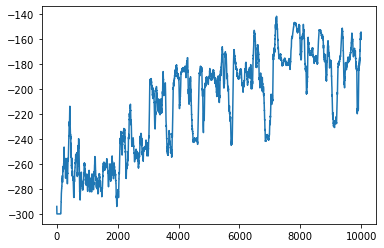

In [12]:
mean_rewards = np.zeros(n_episodes)
for t in range(n_episodes):
    mean_rewards[t] = np.mean(total_reward[t:t+50]) # get the mean reward for every 50 episodes
plt.plot(mean_rewards)
plt.savefig('MountainCar.png') # save it to a png file